In [1]:
import os
import cv2
import time 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [2]:
train_data_dir = r"C:\Users\shreyash\Desktop\Msc Project Data\Train"
valid_data_dir = r"C:\Users\shreyash\Desktop\Msc Project Data\Valid"
test_data_dir = r"C:\Users\shreyash\Desktop\Msc Project Data\Test"
class_names = sorted(os.listdir(train_data_dir))
num_classes = len(class_names)

In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_label in class_names:
        class_path = os.path.join(folder, class_label)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Adjust the size according to your preference
                img = img / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(class_names.index(class_label))
    return np.array(images), np.array(labels)

x_train, y_train = load_images_from_folder(train_data_dir)
x_val,y_val = load_images_from_folder(train_data_dir)

In [4]:
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

In [5]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [5]:
print("Number of images in x_train:", x_train.shape[0])
print("Number of labels in y_train:", y_train.shape[0])

Number of images in x_train: 7771
Number of labels in y_train: 7771


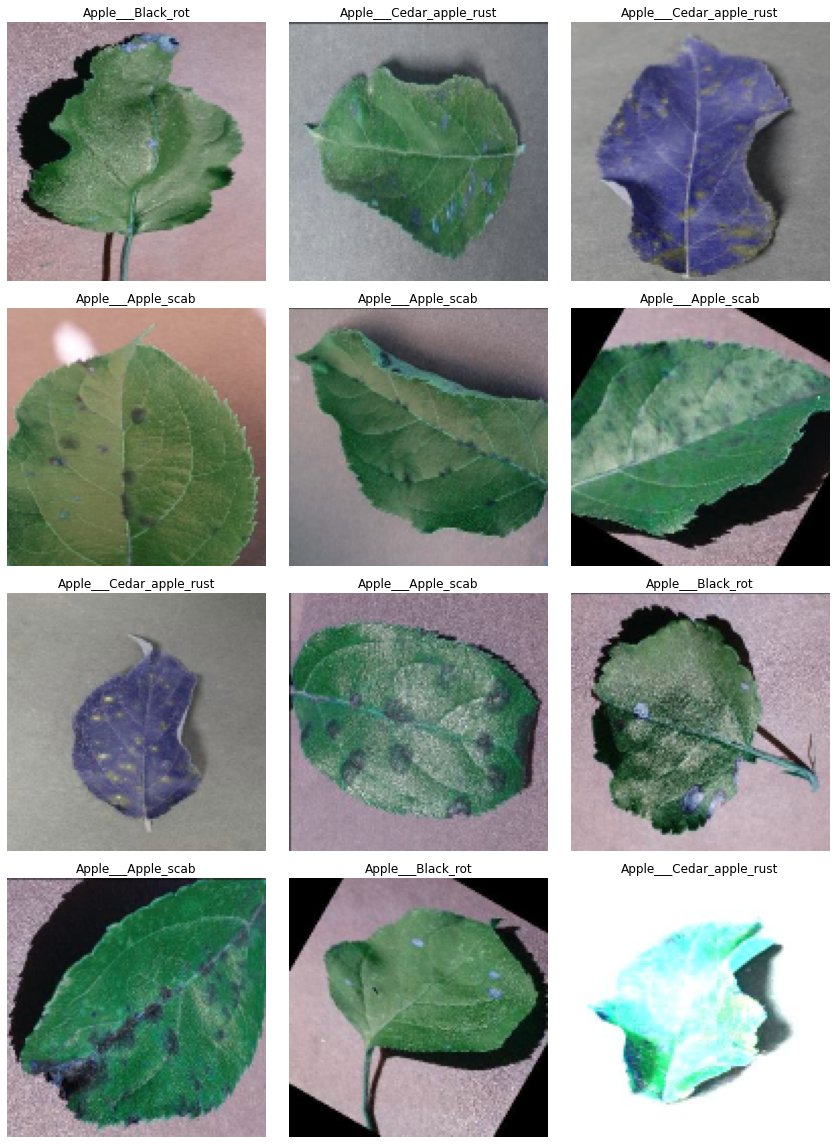

In [6]:
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

# Loop through the images and plot them in groups of 3
for i in range(12):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    # Convert the pixel values to the appropriate range [0, 255]
    image = (x_train[i] * 255).astype('uint8')
    ax.imshow(image)
    ax.axis('off')
    # Get the class label for the current image
    class_label = y_train[i]
    # Add the class name as the title
    ax.set_title(class_names[class_label], fontsize=12)

plt.tight_layout()
plt.show()


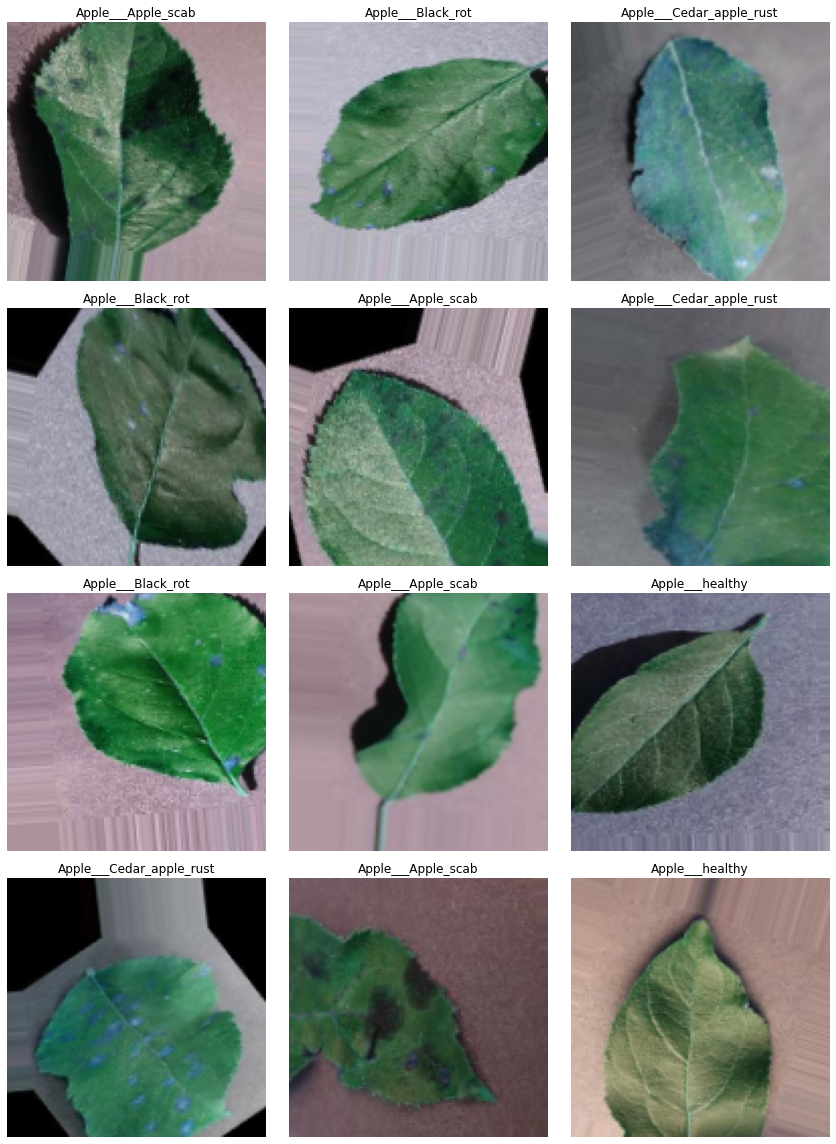

In [7]:
# Create an ImageDataGenerator for data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,        # Random rotation between -20 and +20 degrees
    width_shift_range=0.2,    # Randomly shift width by a maximum of 20% of the image width
    height_shift_range=0.2,   # Randomly shift height by a maximum of 20% of the image height
    horizontal_flip=True,     # Randomly flip the images horizontally
    vertical_flip=False,      # Do not flip the images vertically
    zoom_range=0.2,           # Randomly zoom images by 20%
    fill_mode='nearest',      # Fill missing pixels with the nearest value
)

# Create a new directory to store augmented images (optional)
augmented_dir = r"C:\Users\shreyash\Desktop\Msc Project Data\Augmented"
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

# Generate augmented batches and save the augmented images
batch_size = 32
num_augmented_images = 0
for x_batch, y_batch in data_augmentation.flow(x_train, y_train, batch_size=batch_size, save_to_dir=augmented_dir, save_prefix='aug', save_format='jpeg'):
    num_augmented_images += len(x_batch)
    if num_augmented_images >= len(x_train):
        break

# Visualize a subset of the augmented images
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

# Loop through the augmented images and plot them in groups of 3
for i, (image, class_label) in enumerate(zip(x_batch[:12], y_batch[:12])):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    # Convert the pixel values to the appropriate range [0, 255]
    image = (image * 255).astype('uint8')
    ax.imshow(image)
    ax.axis('off')
    # Add the class name as the title
    ax.set_title(class_names[class_label], fontsize=12)

plt.tight_layout()
plt.show()


In [27]:
x_train.shape

(7771, 128, 128, 3)

In [76]:
# Define the number of classes
num_classes = 4

# Input layer for the hybrid model
input_layer = tf.keras.Input(shape=(128, 128, 3))

# Convolutional layers for feature extraction
conv_layers = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
conv_layers = layers.MaxPooling2D(pool_size=(2, 2))(conv_layers)
conv_layers = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(conv_layers)
conv_layers = layers.MaxPooling2D(pool_size=(2, 2))(conv_layers)
conv_layers = layers.Flatten()(conv_layers)

# Fully connected layers for classification
fc_layers = layers.Dense(128, activation='relu')(conv_layers)
fc_layers = layers.Dropout(0.5)(fc_layers)  # Add dropout for regularization

# Classification layer
output = layers.Dense(num_classes, activation='softmax')(fc_layers)

# Create the hybrid model
hybrid_model = tf.keras.Model(inputs=input_layer, outputs=output)

hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
batch_size = 32
epochs = 10

start_time = time.time()

history = hybrid_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Hybrid Model fitting took {elapsed_time:.2f} seconds.")

# Evaluate the model
test_loss, test_accuracy = hybrid_model.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
195/195 [==============================] - 102s 489ms/step - loss: 0.6984 - accuracy: 0.7384 - val_loss: 0.3911 - val_accuracy: 0.8598
Epoch 2/10
195/195 [==============================] - 89s 454ms/step - loss: 0.3098 - accuracy: 0.8879 - val_loss: 0.2998 - val_accuracy: 0.8894
Epoch 3/10
195/195 [==============================] - 86s 442ms/step - loss: 0.2355 - accuracy: 0.9146 - val_loss: 0.1822 - val_accuracy: 0.9325
Epoch 4/10
195/195 [==============================] - 91s 465ms/step - loss: 0.1823 - accuracy: 0.9326 - val_loss: 0.1568 - val_accuracy: 0.9505
Epoch 5/10
195/195 [==============================] - 87s 445ms/step - loss: 0.1222 - accuracy: 0.9575 - val_loss: 0.1415 - val_accuracy: 0.9511
Epoch 6/10
195/195 [==============================] - 88s 451ms/step - loss: 0.1140 - accuracy: 0.9591 - val_loss: 0.2621 - val_accuracy: 0.9016
Epoch 7/10
195/195 [==============================] - 90s 460ms/step - loss: 0.0997 - accuracy: 0.9648 - val_loss: 0.1192 - val_a

In [38]:
hybrid_model.save(r'C:\Users\shreyash\Desktop\Msc Project Data\Hybrid_model/hybrid_model')

INFO:tensorflow:Assets written to: C:\Users\shreyash\Desktop\Msc Project Data\Hybrid_model/hybrid_model\assets


INFO:tensorflow:Assets written to: C:\Users\shreyash\Desktop\Msc Project Data\Hybrid_model/hybrid_model\assets


In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

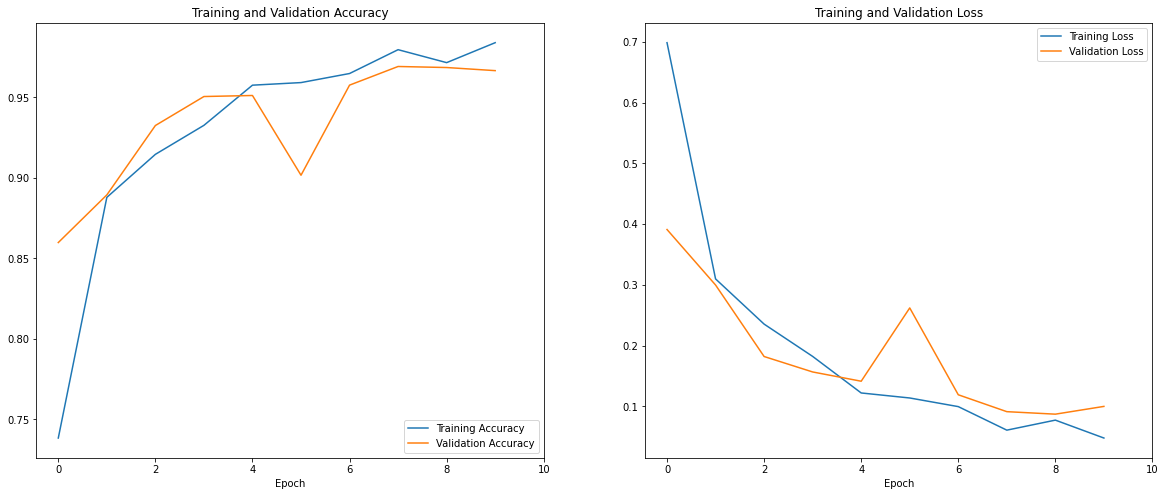

In [90]:
import matplotlib.pyplot as plt

EPOCHS = 10

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xticks(epoch_ticks)  # Set the epoch ticks
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xticks(epoch_ticks)  # Set the epoch ticks
plt.xlabel('Epoch')

plt.show()


In [59]:
hybrid_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 57600)             0   

In [79]:
import numpy as np
from sklearn.metrics import classification_report
class_names = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy']
y_pred_probs = hybrid_model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)
report_hybrid = classification_report(y_val, y_pred, target_names=class_names)

243/243 [==============================] - 32s 98ms/step


In [80]:
print(report_hybrid)

                          precision    recall  f1-score   support

      Apple___Apple_scab       0.99      0.99      0.99      2016
       Apple___Black_rot       0.99      1.00      1.00      1987
Apple___Cedar_apple_rust       1.00      1.00      1.00      1760
         Apple___healthy       0.99      0.99      0.99      2008

                accuracy                           0.99      7771
               macro avg       0.99      0.99      0.99      7771
            weighted avg       0.99      0.99      0.99      7771



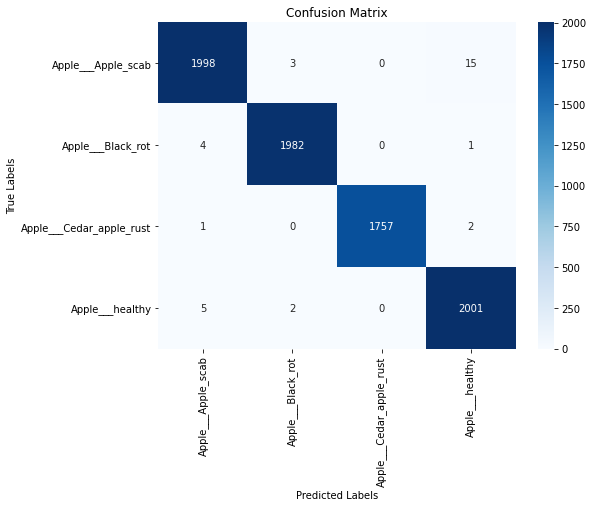

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [45]:
test_images = os.listdir(test_data_dir)
predicted_labels = []

for file in test_images:
    # Load and preprocess the test image
    image_path = os.path.join(test_data_dir, file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))  # Resize the image to match the input size of the model
    image = image.astype('float32') / 255.0  # Normalize the pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension as
    
    # Predict the class label for the test image
    prediction = hybrid_model.predict(image)
    predicted_label = np.argmax(prediction, axis=1)[0]  # Get the index of the class with the highest probability
    predicted_labels.append(predicted_label)

    # Display the predicted label for the current test image
    print(f"Image: {file}, Predicted Label: {predicted_label}")

# Convert the predicted labels to a numpy array
predicted_labels = np.array(predicted_labels)

1/1 [==============================] - 1s 1s/step
Image: AppleCedarRust1.JPG, Predicted Label: 2
1/1 [==============================] - 1s 1s/step
Image: AppleCedarRust2.JPG, Predicted Label: 2
1/1 [==============================] - 1s 1s/step
Image: AppleCedarRust3.JPG, Predicted Label: 2
1/1 [==============================] - 1s 965ms/step
Image: AppleScab1.JPG, Predicted Label: 0
1/1 [==============================] - 1s 976ms/step
Image: AppleScab2.JPG, Predicted Label: 0
1/1 [==============================] - 1s 994ms/step
Image: AppleScab3.JPG, Predicted Label: 0


In [98]:
hybrid_model.save(r"C:\Users\shreyash\Desktop\Msc Project Data\hybrid_model.h5")

In [101]:
saved_hybrid_model = tf.keras.models.load_model('hybrid_model.h5')
# Convert the Keras model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(saved_hybrid_model)
tflite_model = converter.convert()
# Specify the path to save the TFLite model
tflite_model_path = r'C:\Users\shreyash\Desktop\Msc Project Data\Models\tf_hybrid.tflite'

# Save the TFLite model to a file
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved:", tflite_model_path)

INFO:tensorflow:Assets written to: C:\Users\shreyash\AppData\Local\Temp\tmpvc9xwpfy\assets


INFO:tensorflow:Assets written to: C:\Users\shreyash\AppData\Local\Temp\tmpvc9xwpfy\assets


TFLite model saved: C:\Users\shreyash\Desktop\Msc Project Data\Models\tf_hybrid.tflite


# CNN Model

In [71]:
import time
# Define the number of classes
num_classes = 4

# Build the simple CNN model
model_cnn = tf.keras.Sequential([
    # Convolutional layers
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    # Fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_batch_size = 32
cnn_epochs =10

start_time = time.time()

history_cnn = model_cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Model fitting took {elapsed_time:.2f} seconds.")

Epoch 1/10
195/195 [==============================] - 147s 717ms/step - loss: 0.7360 - accuracy: 0.6908 - val_loss: 0.3993 - val_accuracy: 0.8379
Epoch 2/10
195/195 [==============================] - 140s 716ms/step - loss: 0.2598 - accuracy: 0.9054 - val_loss: 0.3010 - val_accuracy: 0.8791
Epoch 3/10
195/195 [==============================] - 140s 718ms/step - loss: 0.1397 - accuracy: 0.9505 - val_loss: 0.2814 - val_accuracy: 0.8952
Epoch 4/10
195/195 [==============================] - 140s 716ms/step - loss: 0.1402 - accuracy: 0.9476 - val_loss: 0.2343 - val_accuracy: 0.9209
Epoch 5/10
195/195 [==============================] - 146s 747ms/step - loss: 0.1013 - accuracy: 0.9643 - val_loss: 0.0899 - val_accuracy: 0.9659
Epoch 6/10
195/195 [==============================] - 155s 796ms/step - loss: 0.0703 - accuracy: 0.9767 - val_loss: 0.1232 - val_accuracy: 0.9582
Epoch 7/10
195/195 [==============================] - 161s 824ms/step - loss: 0.0796 - accuracy: 0.9720 - val_loss: 0.1391 -

In [105]:
cnn_acc = history_cnn.history['accuracy']
cnn_val_acc = history_cnn.history['val_accuracy']

cnn_loss = history_cnn.history['loss']
cnn_val_loss = history_cnn.history['val_loss']

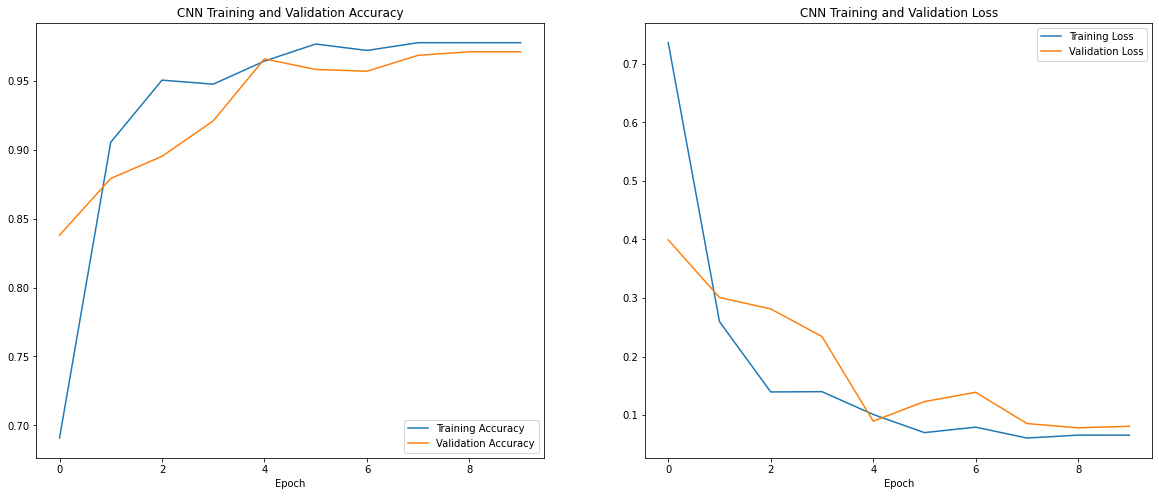

In [106]:
import matplotlib.pyplot as plt

EPOCHS = 10

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), cnn_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), cnn_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), cnn_loss, label='Training Loss')
plt.plot(range(EPOCHS), cnn_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epoch')

plt.show()

In [93]:
import numpy as np
from sklearn.metrics import classification_report
class_names = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy']
y_pred_probs_cnn = model_cnn.predict(x_val)
y_pred_cnn = np.argmax(y_pred_probs_cnn, axis=1)
report_cnn = classification_report(y_val, y_pred_cnn, target_names=class_names)

243/243 [==============================] - 59s 208ms/step


In [94]:
print(report_cnn)

                          precision    recall  f1-score   support

      Apple___Apple_scab       0.97      0.99      0.98      2016
       Apple___Black_rot       1.00      0.99      0.99      1987
Apple___Cedar_apple_rust       1.00      0.99      0.99      1760
         Apple___healthy       0.99      0.99      0.99      2008

                accuracy                           0.99      7771
               macro avg       0.99      0.99      0.99      7771
            weighted avg       0.99      0.99      0.99      7771



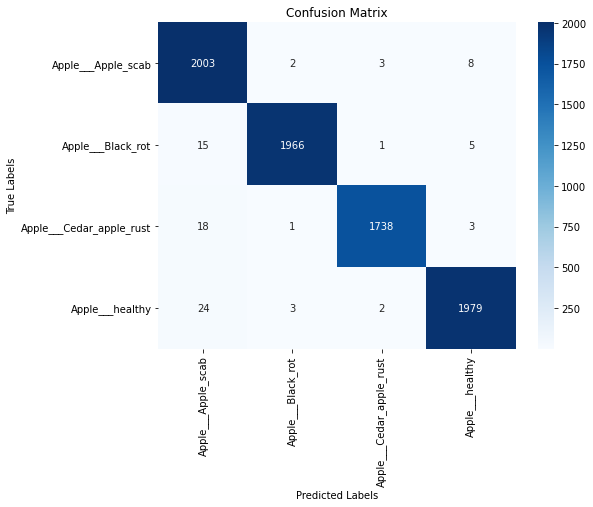

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix_cnn = confusion_matrix(y_val, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 128)      0

In [61]:
test_images = os.listdir(test_data_dir)
predicted_labels = []

for file in test_images:
    # Load and preprocess the test image
    image_path = os.path.join(test_data_dir, file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))  # Resize the image to match the input size of the model
    image = image.astype('float32') / 255.0  # Normalize the pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension as
    
    # Predict the class label for the test image
    prediction = model_cnn.predict(image)
    predicted_label = np.argmax(prediction, axis=1)[0]  # Get the index of the class with the highest probability
    predicted_labels.append(predicted_label)

    # Display the predicted label for the current test image
    print(f"Image: {file}, Predicted Label: {predicted_label}")

# Convert the predicted labels to a numpy array
predicted_labels = np.array(predicted_labels)

1/1 [==============================] - 1s 1s/step
Image: AppleCedarRust1.JPG, Predicted Label: 2
1/1 [==============================] - 1s 1s/step
Image: AppleCedarRust2.JPG, Predicted Label: 2
1/1 [==============================] - 1s 1s/step
Image: AppleCedarRust3.JPG, Predicted Label: 2
1/1 [==============================] - 1s 1s/step
Image: AppleScab1.JPG, Predicted Label: 0
1/1 [==============================] - 1s 1s/step
Image: AppleScab2.JPG, Predicted Label: 0
1/1 [==============================] - 1s 1s/step
Image: AppleScab3.JPG, Predicted Label: 0
1/1 [==============================] - 1s 1s/step
Image: Scab.jpg, Predicted Label: 1


# MLP MODEL

In [97]:
# Define the number of classes
num_classes = 4

# Build the MLP model
MLP_model = tf.keras.Sequential([
    layers.Flatten(input_shape=(128, 128, 3)),  # Flatten the input images
    layers.Dense(512, activation='relu'),       # Dense layer with 512 units and ReLU activation
    layers.Dense(256, activation='relu'),       # Dense layer with 256 units and ReLU activation
    layers.Dense(128, activation='relu'),       # Dense layer with 128 units and ReLU activation
    layers.Dense(num_classes, activation='softmax')  # Output layer with 'num_classes' units and softmax activation
])

# Compile the model
MLP_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10

MLP_start_time = time.time()

history_mlp = MLP_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

MLP_end_time = time.time()
MLP_elapsed_time = MLP_end_time - MLP_start_time
print(f"MLP Model fitting took {MLP_elapsed_time:.2f} seconds.")

Epoch 1/10
195/195 [==============================] - 81s 364ms/step - loss: 3.5989 - accuracy: 0.4765 - val_loss: 0.8399 - val_accuracy: 0.6341
Epoch 2/10
195/195 [==============================] - 65s 334ms/step - loss: 0.8019 - accuracy: 0.6840 - val_loss: 0.6576 - val_accuracy: 0.7260
Epoch 3/10
195/195 [==============================] - 59s 304ms/step - loss: 0.6367 - accuracy: 0.7513 - val_loss: 0.5555 - val_accuracy: 0.7672
Epoch 4/10
195/195 [==============================] - 61s 314ms/step - loss: 0.5831 - accuracy: 0.7720 - val_loss: 0.6147 - val_accuracy: 0.7370
Epoch 5/10
195/195 [==============================] - 62s 319ms/step - loss: 0.5606 - accuracy: 0.7833 - val_loss: 0.7437 - val_accuracy: 0.7080
Epoch 6/10
195/195 [==============================] - 62s 319ms/step - loss: 0.5433 - accuracy: 0.7881 - val_loss: 0.4515 - val_accuracy: 0.8212
Epoch 7/10
195/195 [==============================] - 60s 311ms/step - loss: 0.4574 - accuracy: 0.8187 - val_loss: 0.7318 - val_ac

In [98]:
mlp_acc = history_mlp.history['accuracy']
mlp_val_acc = history_mlp.history['val_accuracy']

mlp_loss = history_mlp.history['loss']
mlp_val_loss = history_mlp.history['val_loss']

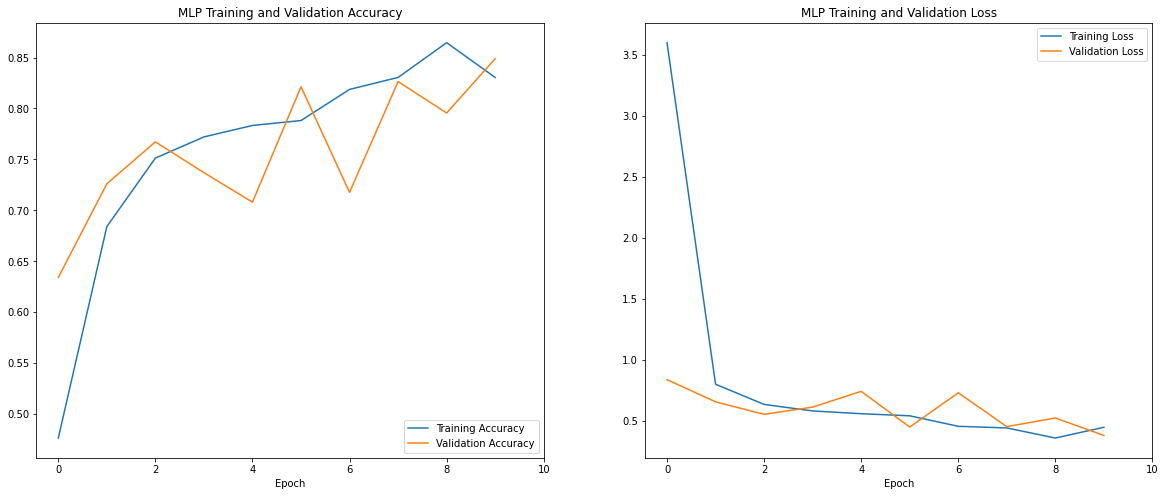

In [99]:
import matplotlib.pyplot as plt

EPOCHS = 10
epoch_ticks = [2 * i for i in range(EPOCHS // 2 + 1)] 

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), mlp_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), mlp_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('MLP Training and Validation Accuracy')
plt.xticks(epoch_ticks)  # Set the epoch ticks
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), mlp_loss, label='Training Loss')
plt.plot(range(EPOCHS), mlp_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('MLP Training and Validation Loss')
plt.xticks(epoch_ticks)  # Set the epoch ticks
plt.xlabel('Epoch')

plt.show()

In [112]:
from sklearn.metrics import classification_report
class_names = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy']
y_pred_probs_mlp = MLP_model.predict(x_val)
y_pred_mlp = np.argmax(y_pred_probs_mlp, axis=1)
report_mlp = classification_report(y_val, y_pred_mlp, target_names=class_names)

243/243 [==============================] - 12s 27ms/step


In [113]:
print(report_mlp)

                          precision    recall  f1-score   support

      Apple___Apple_scab       0.76      0.92      0.83      2016
       Apple___Black_rot       0.89      0.88      0.89      1987
Apple___Cedar_apple_rust       0.97      0.81      0.88      1760
         Apple___healthy       0.95      0.90      0.93      2008

                accuracy                           0.88      7771
               macro avg       0.89      0.88      0.88      7771
            weighted avg       0.89      0.88      0.88      7771



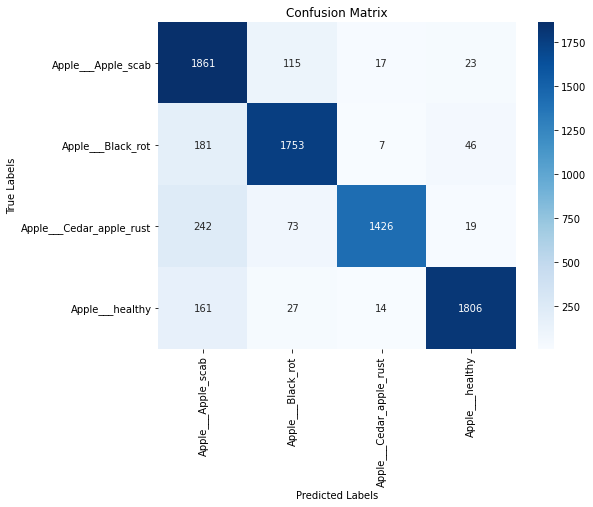

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix_mlp = confusion_matrix(y_val, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

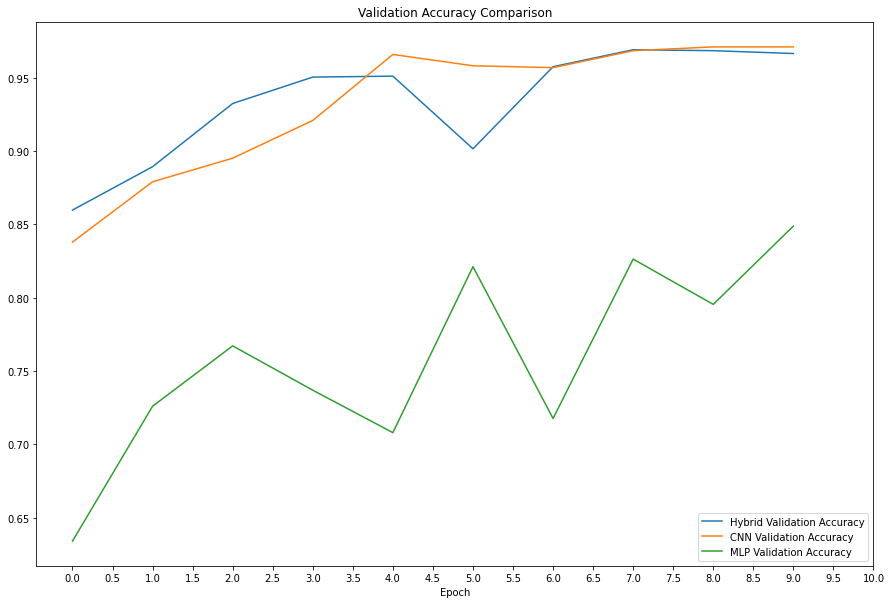

In [108]:
EPOCHS = 10
epoch_ticks = [i / 2 for i in range(EPOCHS * 2 + 1)]  # Ticks at every 0.5

plt.figure(figsize=(15,10))

# Plot Hybrid Model Validation Accuracy
plt.plot(range(EPOCHS), val_acc, label='Hybrid Validation Accuracy')

# Plot CNN Model Validation Accuracy
plt.plot(range(EPOCHS), cnn_val_acc, label='CNN Validation Accuracy')

# Plot MLP Model Validation Accuracy
plt.plot(range(EPOCHS), mlp_val_acc, label='MLP Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Validation Accuracy Comparison')
plt.xticks(epoch_ticks)  # Set the epoch ticks
plt.xlabel('Epoch')

plt.show()


In [115]:
conf_matrix_mlp

array([[1861,  115,   17,   23],
       [ 181, 1753,    7,   46],
       [ 242,   73, 1426,   19],
       [ 161,   27,   14, 1806]], dtype=int64)

In [111]:
conf_matrix_cnn

array([[2003,    2,    3,    8],
       [  15, 1966,    1,    5],
       [  18,    1, 1738,    3],
       [  24,    3,    2, 1979]], dtype=int64)

In [116]:
conf_matrix

array([[2011,    0,    0,    5],
       [   0, 1987,    0,    0],
       [   1,    0, 1759,    0],
       [   4,    0,    0, 2004]], dtype=int64)

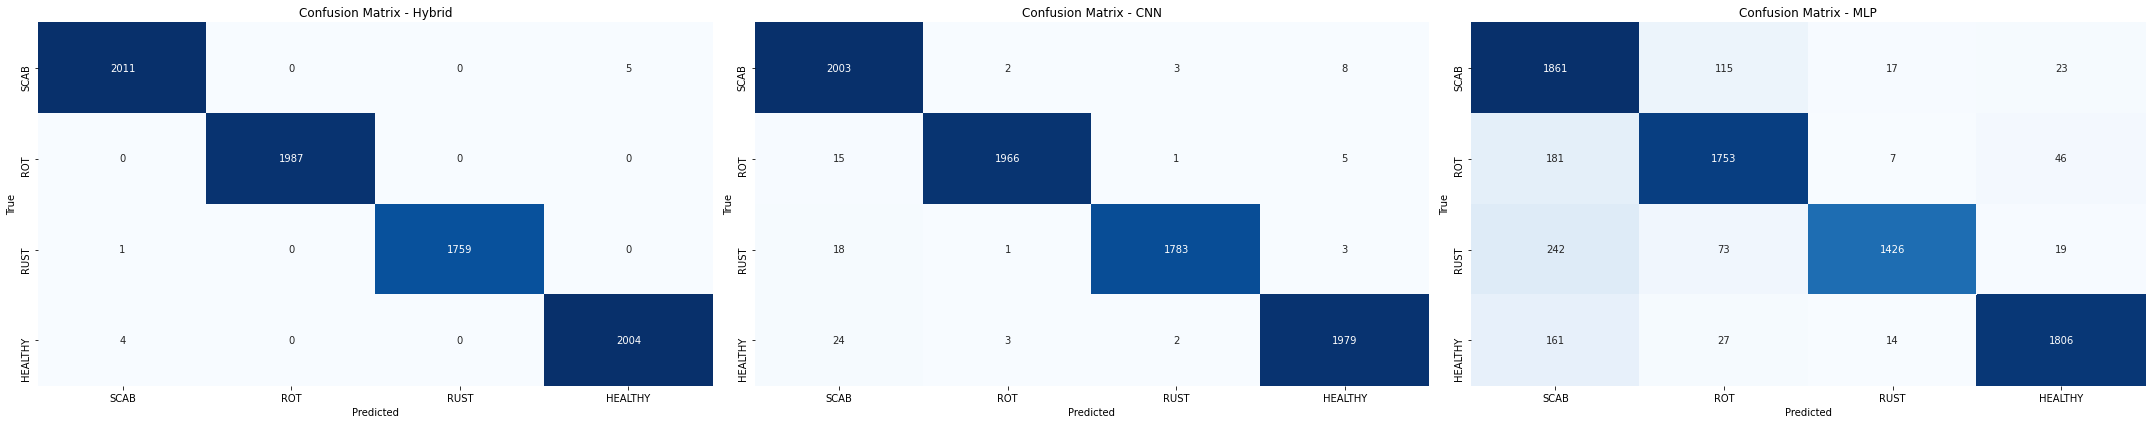

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate example confusion matrices for each model
hybrid_confusion = np.array([[2011,0,0,5],
                        [0,1987,0,0],
                        [1,0, 1759,0],
                        [4,0,0,2004]])
                       
cnn_confusion = np.array([[2003, 2, 3, 8],
                          [15, 1966, 1, 5],
                          [18, 1, 1783,3],
                          [24, 3, 2, 1979]])

mlp_confusion = np.array([[1861, 115, 17, 23],
                          [181, 1753, 7, 46],
                          [242, 73, 1426, 19],
                          [161, 27, 14, 1806]])

# Class names
class_names = ['SCAB', 'ROT', 'RUST', 'HEALTHY']

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(30, 6))
for idx, (confusion, model_name) in enumerate(zip([hybrid_confusion, cnn_confusion, mlp_confusion],
                                                   ['Hybrid', 'CNN', 'MLP'])):
    ax = axes[idx]
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
plt.tight_layout()
plt.show()
